# Getting Started

Follow the general instructions from hw1_Q1

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('/teamspace/studios/this_studio/MAI_DUL_WS24')
# os.chdir('../..')
os.getcwd()

'/teamspace/studios/this_studio/MAI_DUL_WS24'

In [2]:
# run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/

# install latest version deepul package
!pip install -e .

Obtaining file:///teamspace/studios/this_studio/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///teamspace/studios/this_studio/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


# Question 2 PixelCNNs part (b) - optional

## PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
)

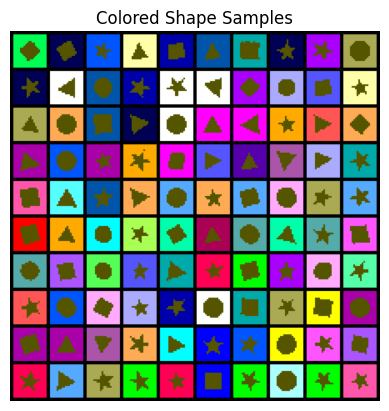

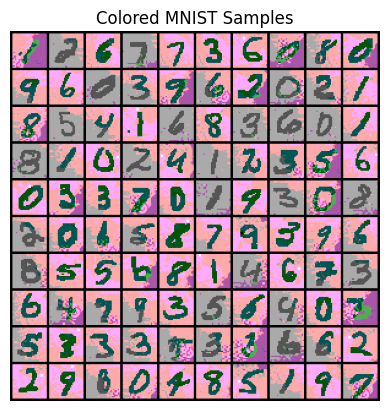

In [4]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **For simplification, assume color channels to be independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm


In [6]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type='A', padding='same'):
        super().__init__(in_channels, out_channels, kernel_size, padding=padding)
        self.register_buffer('mask', torch.ones_like(self.weight.data))
        
        # Create mask
        _, _, H, W = self.weight.shape
        mask = torch.ones(H, W)
        mask[H//2, W//2:] = 0
        mask[H//2 + 1:] = 0
        
        if mask_type == 'A':
            mask[H//2, W//2] = 0
            
        self.mask = self.mask * mask[None, None, :, :]
        
    def forward(self, x):
        self.weight.data = self.weight.data * self.mask
        return super().forward(x)

In [7]:
class LayerNorm(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.norm = nn.LayerNorm([num_channels])
    
    def forward(self, x):
        # Move channels to last dimension for layer norm
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        return x.permute(0, 3, 1, 2)

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, num_filters):
        super().__init__()
        self.conv1 = MaskedConv2d(num_filters, num_filters, 7, 'B')
        self.conv2 = MaskedConv2d(num_filters, num_filters, 7, 'B')
        self.ln1 = LayerNorm(num_filters)
        self.ln2 = LayerNorm(num_filters)
        
    def forward(self, x):
        out = self.ln1(x)
        out = F.relu(out)
        out = self.conv1(out)
        out = self.ln2(out)
        out = F.relu(out)
        out = self.conv2(out)
        return x + out

In [9]:
class PixelCNN(nn.Module):
    def __init__(self, image_shape):
        super().__init__()
        self.height, self.width, self.channels = image_shape
        num_filters = 120
        
        # Initial convolution
        self.conv_in = MaskedConv2d(self.channels, num_filters, 7, 'A')
        
        # Stack of residual blocks
        self.res_blocks = nn.ModuleList([
            ResidualBlock(num_filters) for _ in range(8)
        ])
        
        # Output layers - one for each color channel
        self.out_layers = nn.ModuleList([
            nn.Conv2d(num_filters, 4, 1) for _ in range(self.channels)
        ])
        
    def forward(self, x):
        
        # Initial convolution
        x = x.permute(0, 3, 1, 2).float()  # NHWC -> NCHW
        out = self.conv_in(x)
        
        # Residual blocks
        for block in self.res_blocks:
            out = block(out)
            
        # Get logits for each color channel
        logits = []
        for layer in self.out_layers:
            logits.append(layer(out))
            
        return logits

In [10]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    train_losses = []
    pbar = tqdm(train_loader, unit='batch')

    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Get logits for each color channel
        logits = model(data)
        
        # Calculate loss
        loss = 0
        for c in range(model.channels):
            loss += F.cross_entropy(logits[c].reshape(-1, 4), data[..., c].reshape(-1).long())
        loss = loss / (model.height * model.width * model.channels)  # per dimension
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        pbar.set_description(desc=f"batch_loss={loss.item():.4f}")

    return train_losses


In [11]:
def evaluate_loss(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            logits = model(data)
            
            loss = 0
            for c in range(model.channels):
                loss += F.cross_entropy(logits[c].reshape(-1, 4), data[..., c].reshape(-1).long())
            loss = loss / (model.height * model.width * model.channels)
            total_loss += loss.item()
            
    return total_loss / len(data_loader)

In [30]:
def sample(model, n_samples, image_shape, device):
    model.eval()
    height, width, channels = image_shape
    samples = torch.zeros((n_samples, height, width, channels), device=device)
    
    with torch.no_grad():
        for h in range(height):
            for w in range(width):
                for c in range(channels):
                    logits = model(samples)
                    # print(f"{logits.shape=}")
                    probs = F.softmax(logits[c][:, :, h, w], dim=1)
                    print(f"{probs.shape=}")
                    samples[:, h, w, c] = torch.multinomial(probs, 1).float()
                    
    return samples.cpu().numpy()

In [31]:
# Generate samples
image_shape =(20, 20, 3)
device = torch.device("cuda")
model = PixelCNN(image_shape).to(device)


samples = sample(model, 100, image_shape, device)

probs.shape=torch.Size([100, 4])


RuntimeError: expand(torch.cuda.FloatTensor{[100, 1]}, size=[100]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [18]:
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    torch.manual_seed(1)

    # Set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon GPU)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    
    # Hyperparameters
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 2 if dset_id == 1 else 5  # More epochs for MNIST

    if torch.cuda.is_available():
        kwargs = {'num_workers': 4, 'pin_memory': True}
    elif torch.backends.mps.is_available():
        kwargs = {'num_workers': 4}
    else:
        kwargs = {}

    # Convert numpy arrays to torch tensors
    train_tensor = torch.from_numpy(train_data).float()
    test_tensor = torch.from_numpy(test_data).float()

    # Create datasets
    train_dataset = TensorDataset(train_tensor, torch.zeros(len(train_tensor)))
    test_dataset = TensorDataset(test_tensor, torch.zeros(len(test_tensor)))

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
    
    # Initialize model and optimizer
    model = PixelCNN(image_shape).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store losses
    train_losses = []
    test_losses = [evaluate_loss(model, test_loader, device)]

    # Training loop
    for epoch in range(num_epochs):
        epoch_losses = train_epoch(model, train_loader, optimizer, device)
        train_losses.extend(epoch_losses)
            
        # Evaluate on test set
        test_loss = evaluate_loss(model, test_loader, device)
        test_losses.append(test_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}')

    # Generate samples
    samples = sample(model, 100, image_shape, device)
        
    return np.array(train_losses), np.array(test_losses), samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



In [19]:
q2b_save_results(1, 'b', q2_b)

Using CUDA


  0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 1/2, Test Loss: 0.0004


  0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 2/2, Test Loss: 0.0019


RuntimeError: expand(torch.cuda.FloatTensor{[100, 1]}, size=[100]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [ ]:
q2b_save_results(2, 'b', q2_b)